In [ ]:
!conda install -c intel scikit-learn

# Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets_escenario1.2.csv', sep = ',')

In [6]:
tweets_df.shape

(627, 3)

In [7]:
tweets_df.head()

,full_text,sentiment,emotion
0,"@IvanDuque Sus socios de las AGC tienen este platanal vuelto mierda, pero no haces nada, usted inservible, ha logrado la peor inflación en Colombia y solo pública maricadas sin sentido, se robó las elecciones para entregar el país, valiente idiota tenemos de presidente.",negative,anger
1,@AlvaroUribeVel Ellos también celebran por que Maduro PetroGustavo Ivan Cepeda Timo Teodora Bobolivar entre muchos más sufren de insomnio.\nUribe Velez Alvarito no los deja dormir\nEl enemigo para las elecciones no es Fico.... Sino el Excelentísimo y más Grande Presidente que ha tenido Colombia,negative,anger
2,"@PDleh @cokycafe @PGN_COL En Colombia existen miles de leyes para controlar los funcionarios públicos pero a la hora de aplicarlas ""se les olvida que existen"". ¿Que más pruebas quieren? ¿Porque avalan unas elecciones, las del 13 de marzo, donde pado de todo lo que no debía de pasar? Escuchamos respuestas",negative,anger
3,Petro ahora es el Capitán América o mejor dicho el Capitán Colombia de ganar las elecciones. No soltara el escudo ni para dormir 😂 https://t.co/k56Dv7id1J,negative,joy
4,"#OtraPregunta \n""Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia""...\nEsto no pinta nada bien... y si además gana Lula en Brasil...\n¿Esto como que va para largo? https://t.co/wpQsl5KoRe",negative,fear


In [8]:
tweets_df.sample(n=400, random_state=4)

,full_text,sentiment,emotion
386,Procuraduría alerta que 2.925 jurados de votación están inhabilitados para elecciones Colombia via @ElColombiano https://t.co/i62hR3wv5r,neutral,fear
545,Colombia. País de las jugaditas...\n\nCon o sin Ley de garantías el Uribismo siempre ha encontrado y encontrará la manera de amañar elecciones y comprar votos.,negative,anger
317,"Con esta ley, que se intentó modificar varias veces en anteriores contiendas, la intención principal era asegurar que las campañas electorales se llevaran a cabo en condiciones igualitarias y transparentes.\n\n#Elecciones2022 #ColombiaDecide \nhttps://t.co/qRNy77hLm6",neutral,joy
567,"Lo peor que le puede pasar a Colombia son las elecciones. Sacan lo mas feo de muchas personas, la intolerancia, el individualismo, la manipulación, etc.\n\nVoy a tener que limpiar mi twitter porque ya me cansé. \n\nNo hay cuerpo que lo resista!",negative,anger
108,@CARLOSFMEJIA @infopresidencia @PGN_COL @FiscaliaCol @CNE_COLOMBIA Hace 4 años un perro rabioso se robó las elecciones,negative,anger
...,...,...,...
398,Advierten inhabilidades en jurados de votación elegidos para elecciones presidenciales https://t.co/oUCjxiVqOi,neutral,anger
559,@MafeCarrascal Hola @MafeCarrascal que pena que nunca pudimos dialogar con usted sobre las elecciones en #Colombia. Ya encontraremos políticos que quieran hablar para la comunidad de colombianos en Ecuador que a sido siempre olvidada por el estado Colombiano.,negative,sadness
492,"@BOLIBAR2 @Registraduria @AndresPastrana_ @AlvaroUribeVel @santiagoangelp Tibisay Lucena colombiana @CNE_COLOMBIA @Doris_MendezC afirmó que el corrupto @Registraduria actuó de manera ""transparente"" en Las pasadas elecciones de congreso, ya sabemos lo que nos espera el 29 de Mayo, recuerde @CNE_COLOMBIA es petrista",negative,fear
430,@jojojorge_ Aquí lo podés encontrar. \n\nhttps://t.co/GZQIklXmNZ,neutral,joy


In [9]:
df2 = tweets_df.sample(n=400).copy()
len(df2)

400

In [10]:
df2.to_csv('Dataset.csv')

In [11]:
df2['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.6800
neutral     0.2725
positive    0.0475
Name: sentiment, dtype: float64

In [12]:
df2['emotion'].value_counts(dropna = False, normalize = True)

anger      0.3650
fear       0.2400
sadness    0.2125
joy        0.1825
Name: emotion, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [13]:
# Removing  unlabeled tweets
tweets_labeled_df = df2.loc[df2['sentiment'].notnull()]

In [14]:
tweets_labeled_df.shape

(400, 3)

In [15]:
tweets_unlabeled_df = df2.loc[df2['sentiment'].isnull()]

In [16]:
tweets_unlabeled_df.shape

(0, 3)

In [ ]:
# Scenario 1: Working with all classes

# Scenario 2: Working only with positive and negative classes
# Removing neutral class
#tweets_labeled_df = tweets_labeled_df.loc[tweets_labeled_df['sentiment'].isin(['positive', 'negative'])]

# Scenario 3: Treating neutral as positive classes
#tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})

### Splitting train and test datasets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)


In [18]:
X_train.shape

(320,)

In [19]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.681250
neutral     0.271875
positive    0.046875
Name: sentiment, dtype: float64

In [20]:
X_test.shape

(80,)

In [21]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.675
neutral     0.275
positive    0.050
Name: sentiment, dtype: float64

### Vectorizing texts

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [22]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [23]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [24]:
X_bow = bow.fit_transform(X_train)

In [25]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [26]:
model = RandomForestClassifier()

In [27]:
model.fit(X_bow, y_train)

RandomForestClassifier()

In [28]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

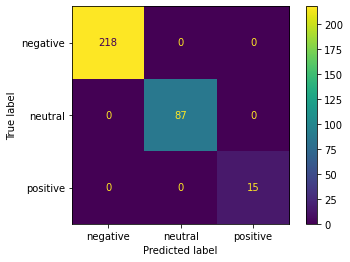

In [29]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

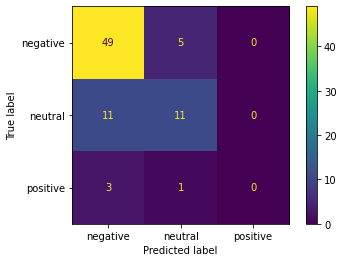

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [ ]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'positive'))

In [31]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.77777778 0.64705882 0.        ]
Recall: [0.90740741 0.5        0.        ]
F1: [0.83760684 0.56410256 0.        ]


C:\Users\Juan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Training and evaluating a model using TF-IDF

In [32]:
model = RandomForestClassifier()

In [33]:
model.fit(X_tfidf, y_train)

RandomForestClassifier()

In [34]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

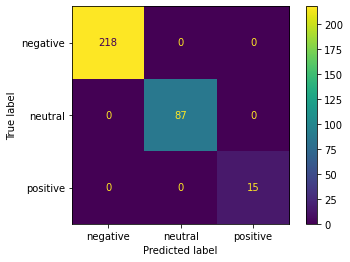

In [35]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

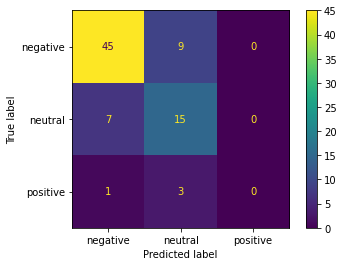

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [ ]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))

In [37]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.8490566  0.55555556 0.        ]
Recall: [0.83333333 0.68181818 0.        ]
F1: [0.8411215 0.6122449 0.       ]


C:\Users\Juan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### How interpret the results?

<table>
    <tbody>
        <tr>
            <td>
                <img src="./imgs/confusion-matrix.png" style="height: 400px;">
            </td>
            <td>
                <img src="./imgs/precision-recall.png" style="height: 600px;">
            </td>
        </tr>
    </tbody>
</table>

### Analyzing errors

In [38]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [39]:
error_df.shape

(80, 3)

In [41]:
error_df.loc[error_df['actual'] != error_df['predicted']].head(100)

,full_text,actual,predicted
6,Y ustedes ¿Ya encontraron su #MatchPresidencial💜Lo pueden hacer acá: https://t.co/0E1tZKypTK\n\n¡Nos gustaría saber quién es su candidato ideal! \nLos leemos en los comentarios 👇 https://t.co/H11SB9EsBV,positive,neutral
7,#Colombia El Tribunal Administrativo de Cundinamarca lanzó duros cuestionamientos al funcionario y dejó la decisión en manos de la Procuraduría.\nhttps://t.co/p10xZKLDMk,neutral,negative
8,"No encontraron otra alternativa que llenar de miedo a Colombia, utilizan sus paramilitares para ganar elecciones. Es ahora o nunca @petrogustavo",positive,negative
9,"Le pedí a ⁦@ElyangelicaNews⁩ , destacada periodista venezolana en el exilio, que le hablara a Colombia y nos contara sobre su país y nuestras elecciones. Esta es una #CartaDesdeElFururo \n\nMi columna en ⁦@RevistaSemana⁩ 👇🏻 https://t.co/ZJAOCFSEMj",neutral,negative
11,En Colombia hace falta un presidente como @nayibbukele que no le teme a nada y va de frente contra las fuerzas oscuras aliadas con políticos que lo único que buscas es inestabilidad en el país previo a elecciones.,positive,negative
15,Hoy amanece colombia secuestrada y sitiada por los amigos de un candidato que lleva las politicas de un expresidente durante los ultimos años y tiene a un pais en jaque!\nTenemos la posibilidad de salvar a colombia en estas elecciones 2022.\nTenemos el derecho al cambio y a la paz https://t.co/gf6MHsLrkc,positive,negative
22,@CARLOSFMEJIA @infopresidencia @FiscaliaCol @PGN_COL @CNE_COLOMBIA Las elecciones a @SenadoGovCo SE DEBER REPETIR…,neutral,negative
30,"Yo no tengo ni beneficios ni problemas derivados de las elecciones presidenciales en Colombia 2022.\n\nElijan a quien elijan, el 30 de mayo me toca ir a trabajar y el 8 de agosto creo que también.",neutral,negative
35,#ElRiesgoEs 🇨🇴\n➖➖➖\n1.- permitir que llegue al poder el comunismo y el socialismo del siglo XXI.\n2.- no votar en conciencia.\n3.- la compra de conciencias débiles… muy débiles.❌\n\n#Colombia #Medellín #Elecciones #Política @LaFM @darcyquinnr @lcvelez @FicoGutierrez @ifmnoticias,negative,neutral
36,"@tinagus2000 Evidentemente la persecución judicial, la aceleración de cosas, las trabas del @cnegobec para la inscripción , el viaje de la fiscal a Colombia y el papel de otras instituciones influyeron en la victoria de Lasso. Al otro candidato lo desgastaron, mucha antes de las elecciones.",neutral,negative
